# LAB 1
All the code and explainations are given in this notebook.

# Task 1

  0%|          | 0/12001 [00:00<?, ?it/s]

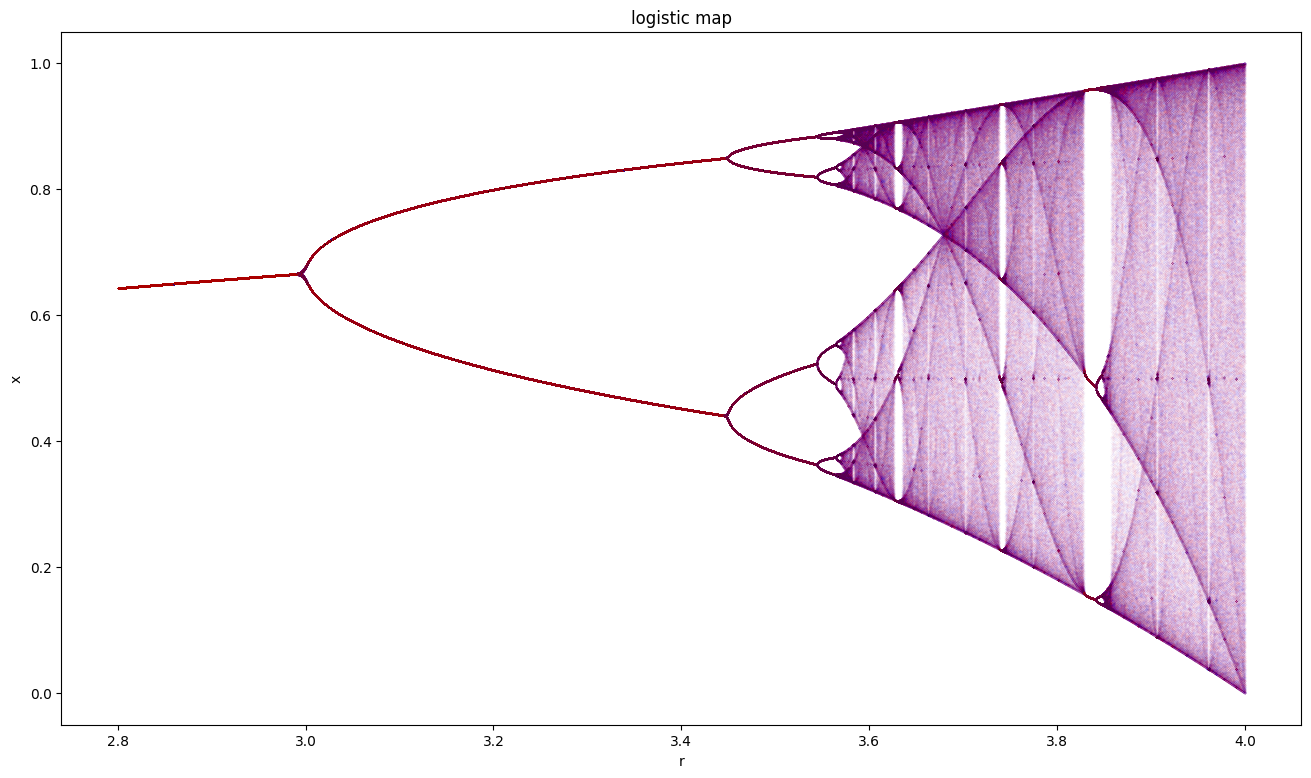

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

interval = (2.8, 4)  # start, end
accuracy = 0.0001
reps = 600  # number of repetitions
numtoplot = 200
a = 1e-5

lims = np.zeros(reps)
lims2 = np.zeros(reps) # initialize for the plot with perturbations

def perturbation(x):
    return a*x**4
    
    
fig, biax = plt.subplots()
fig.set_size_inches(16, 9)

lims[0] = np.random.rand()
lims2[0] = lims[0].copy() # creating the same initial condition as the unperturbed version

for r in tqdm(np.arange(interval[0], interval[1], accuracy)):
    for i in range(reps-1):
        lims[i+1] = r*lims[i]*(1-lims[i])
        lims2[i+1] = r*lims2[i]*(1-lims2[i]) + perturbation(lims2[i])
    
    # without perturbation
    biax.plot([r]*numtoplot, lims[reps-numtoplot:], 'b.', markersize=.02) 
    # with perturbation
    biax.plot([r]*numtoplot, lims2[reps-numtoplot:], 'r.', markersize=.02)


biax.set(xlabel='r', ylabel='x', title='logistic map')
plt.show()

# Task 2
Compute the Feigenbaum constants $\alpha\approx 2.5029$ and $\beta\approx4.6692$
for both maps. $\alpha$ is defined as ...
$\beta = \lim_{n\rightarrow \infty} \frac{a_{n-1} - a_{n-2}}{a_n - a_{n-1}}$ where $a_n$ is 

  0%|          | 0/12001 [00:00<?, ?it/s]

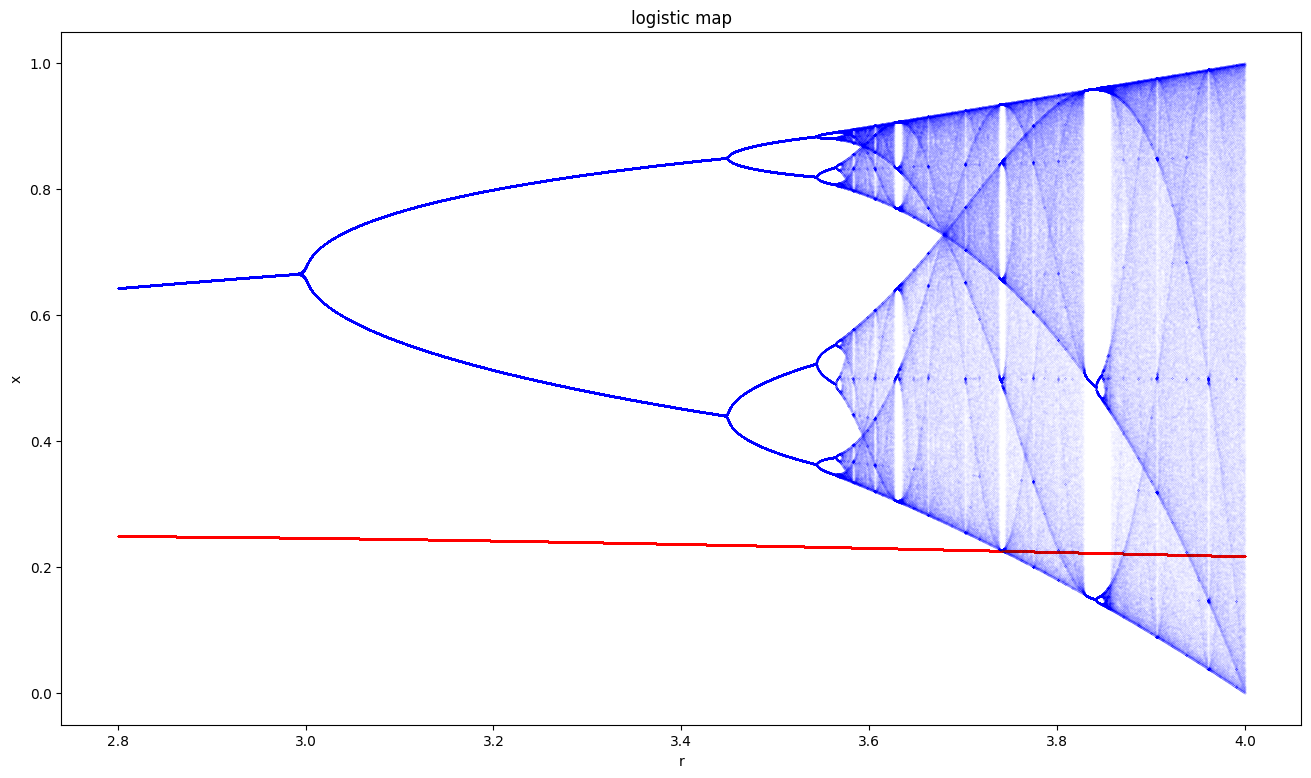

In [4]:
lims = np.zeros(reps)
lims2 = np.zeros(reps) # initialize for the plot with perturbations

def perturbation(x):
    return a*x**4
    
def period2_map(x):
    return r*x*(1-x)*(1-r*x+r*x**2)

fig, biax = plt.subplots()
fig.set_size_inches(16, 9)

lims[0] = np.random.rand()
lims2[0] = lims[0].copy() # creating the same initial condition as the unperturbed version

for r in tqdm(np.arange(interval[0], interval[1], accuracy)):
    for i in range(reps-1):
        lims[i+1] = r*lims[i]*(1-lims[i])
        lims2[i+1] = period2_map(lims2[i])
    
    # without perturbation
    # biax.plot([r]*numtoplot, lims[reps-numtoplot:], 'b.', markersize=.02) 
    # # with perturbation
    # biax.plot([r]*numtoplot, lims2[reps-numtoplot:], 'r.', markersize=.02)


# biax.set(xlabel='r', ylabel='x', title='logistic map')
# plt.show()

In [15]:
def period2_map(x, r=2.9):
    return r*x*(1-x)#r*x*(1-x)*(1-r*x+r*x**2)

x = 0.01
results = []
for i in range(100):
    results.append(x)    
    x = period2_map(x)
results

[0.01,
 0.02871,
 0.08086863411,
 0.21555380456883053,
 0.49036204952372553,
 0.724730618740789,
 0.5785388321011081,
 0.7071117903713624,
 0.6006036482385896,
 0.6956488272871497,
 0.6139924555053728,
 0.6873165882547811,
 0.6232462377173075,
 0.6809500581767338,
 0.6300455216929263,
 0.6759556706340825,
 0.6352148457179598,
 0.6719791419426582,
 0.6392272067363344,
 0.6687857762227541,
 0.6423829490601588,
 0.6662085778691034,
 0.6448866550639176,
 0.6641227858347291,
 0.6468847623925582,
 0.6624321130729569,
 0.648485845063697,
 0.6610606660655873,
 0.6497724393548772,
 0.6599478275880999,
 0.6508084081045576,
 0.6590447897304106,
 0.6516437890928675,
 0.6583120675657179,
 0.6523181388628959,
 0.6577176352626963,
 0.6528629278287149,
 0.657235483357336,
 0.6533033080428162,
 0.6568444776550753,
 0.653659448504409,
 0.6565274442674305,
 0.6539475616542086,
 0.6562704299560985,
 0.6541807028918747,
 0.6560621014817256,
 0.6543693993952119,
 0.6558932567380484,
 0.6545221482604542,
 0.